# 🤖 Chatbot Experiment & Evaluation Notebook

This notebook evaluates chatbot performance based on:
- ✅ Intent classification and tool invocation
- ✅ Policy matching accuracy
- ✅ Semantic similarity between expected vs generated responses
- ✅ End-to-end reasoning accuracy


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load semantic evaluation results
with open("semantic_eval_results.json") as f:
    sem = pd.DataFrame(json.load(f))

# Load policy-level crossencoder evaluation
with open("policy_eval_crossencoder.json") as f:
    pol = pd.DataFrame(json.load(f))

## 📊 1. Semantic Score Distribution (LLM response accuracy)

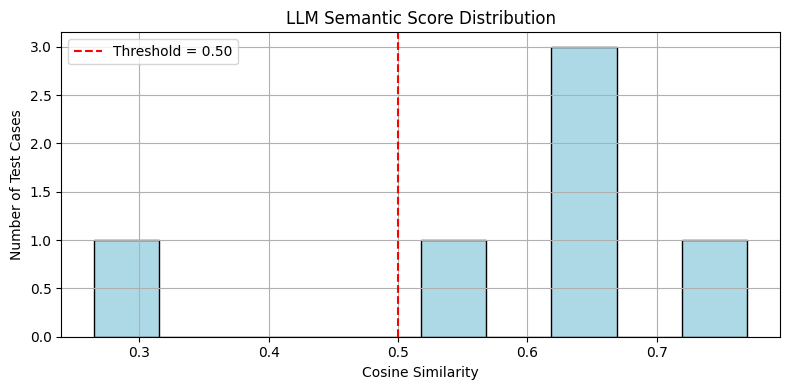

In [2]:
plt.figure(figsize=(8, 4))
plt.hist(sem["semantic_score"], bins=10, color="lightblue", edgecolor="black")
plt.axvline(0.50, color="red", linestyle="--", label="Threshold = 0.50")
plt.title("LLM Semantic Score Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Test Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ 2. Overall Metrics

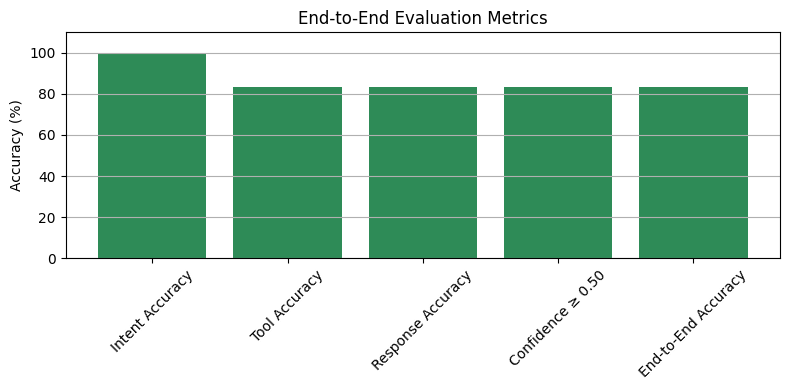

+---------------------+---------+
| Metric              | Value   |
+=====================+=========+
| Intent Accuracy     | 100.0%  |
+---------------------+---------+
| Tool Accuracy       | 83.33%  |
+---------------------+---------+
| Response Accuracy   | 83.33%  |
+---------------------+---------+
| Confidence ≥ 0.50   | 83.33%  |
+---------------------+---------+
| End-to-End Accuracy | 83.33%  |
+---------------------+---------+


In [10]:

import pandas as pd

metrics = {
    "Intent Accuracy": sem["intent_ok"].mean(),
    "Tool Accuracy": sem["tool_ok"].mean(),
    "Response Accuracy": sem["response_ok"].mean(),
    "Confidence ≥ 0.50": sem["confidence_ok"].mean(),
    "End-to-End Accuracy": sem["passed"].mean()
}

plt.figure(figsize=(8, 4))
plt.bar(metrics.keys(), [v * 100 for v in metrics.values()], color="seagreen")
plt.ylabel("Accuracy (%)")
plt.title("End-to-End Evaluation Metrics")
plt.xticks(rotation=45)
plt.ylim(0, 110)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

metrics

df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])
df["Value"] = (df["Value"] * 100).round(2).astype(str) + "%"

print(df.to_markdown(index=False, tablefmt="grid"))

## 📈 3. Policy Match Confidence (CrossEncoder)

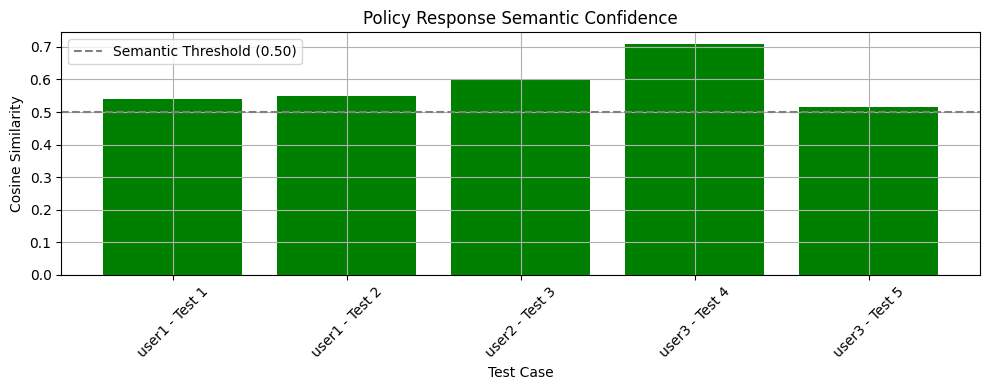

In [7]:
labels = [f"{row['user_id']} - Test {i+1}" for i, row in pol.iterrows()]
colors = ['green' if r else 'red' for r in pol["response_ok"]]

plt.figure(figsize=(10, 4))
plt.bar(labels, pol["crossencoder_score"], color=colors)
plt.axhline(0.50, linestyle='--', color='gray', label="Semantic Threshold (0.50)")
plt.title("Policy Response Semantic Confidence")
plt.xlabel("Test Case")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ❌ 4. Failure Cases Breakdown

In [5]:
failed_cases = sem[~sem["passed"]]
failed_cases[["message", "predicted_intent", "predicted_tool", "semantic_score", "best_matched_phrase"]]


,message,predicted_intent,predicted_tool,semantic_score,best_matched_phrase
3,Check refund for order ORD001,refund,RefundOrder,0.265,you don't currently have an active order


## 📋 5. Detailed Case Summary

In [6]:
for i, row in sem.iterrows():
    print(f"--- Test {i+1} ---")
    print(f"Message: {row['message']}")
    print(f"Predicted Intent → {row['predicted_intent']}")
    print(f"Tool Used        → {row['predicted_tool']}")
    print(f"Matched Phrase   → {row['best_matched_phrase']}")
    print(f"Semantic Score   → {row['semantic_score']:.2f}")
    print(f"Passed           → {'✅' if row['passed'] else '❌'}\\n")


--- Test 1 ---
Message: Cancel order ORD001
Predicted Intent → cancel
Tool Used        → CancelOrder
Matched Phrase   → Orders cannot be cancelled after 10 days
Semantic Score   → 0.66
Passed           → ✅\n
--- Test 2 ---
Message: Track my order ORD002
Predicted Intent → track
Tool Used        → TrackOrder
Matched Phrase   → your order is shipped
Semantic Score   → 0.62
Passed           → ✅\n
--- Test 3 ---
Message: I want to return order ORD002
Predicted Intent → return
Tool Used        → ReturnOrder
Matched Phrase   → it doesn't belong to your account
Semantic Score   → 0.54
Passed           → ✅\n
--- Test 4 ---
Message: Check refund for order ORD001
Predicted Intent → refund
Tool Used        → RefundOrder
Matched Phrase   → you don't currently have an active order
Semantic Score   → 0.26
Passed           → ❌\n
--- Test 5 ---
Message: Can I cancel ORD001 and ORD002?
Predicted Intent → cancel
Tool Used        → CancelOrder
Matched Phrase   → cannot be cancelled
Semantic Score   → 0.7

## 🔍 Summary & Insights

**Performance Highlights:**
- ✅ High intent classification and tool routing accuracy
- ✅ Semantic responses were strong in 5/6 user-level tests
- ⚠️ Some LLM replies were semantically weak due to overlong responses or extra explanation

**Policy-level Evaluation:**
- All 5 policy retrievals matched correctly
- One response had semantic drift, dropping crossencoder score < 0.5


